<a href="https://colab.research.google.com/github/urieliram/analog/blob/main/Analog3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
pip install spectrum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install tslearn==0.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install matrixprofile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install statsmodels==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import time
import timeit
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from math import sqrt
from dtw import *
from scipy import stats
from tslearn import metrics
%matplotlib inline
sns.set_theme(style="white")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Load data

In [8]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

### ETL 5 minutes

In [9]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df = df.set_index('Date')
df_5 = df.resample('5T').mean()
df_5.head()

,SERIE1,SERIE2,SERIE3,SERIE4,SERIE5,SERIE6,SERIE7
Date,,,,,,,
2010-01-01 00:00:00,5547.831152,4353.258496,4927.916309,1355.909058,1697.601026,3396.820703,920.982605
2010-01-01 00:05:00,5535.618164,4348.893457,4916.344433,1353.716626,1699.889233,3397.829590,918.181799
2010-01-01 00:10:00,5529.010351,4331.776856,4897.709473,1346.924121,1697.138647,3424.317334,916.371033
2010-01-01 00:15:00,5514.982032,4330.051758,4879.650098,1346.241382,1705.324194,3421.112500,916.161291
2010-01-01 00:20:00,5472.567285,4314.503906,4863.172266,1334.846802,1674.401562,3409.312451,914.513721


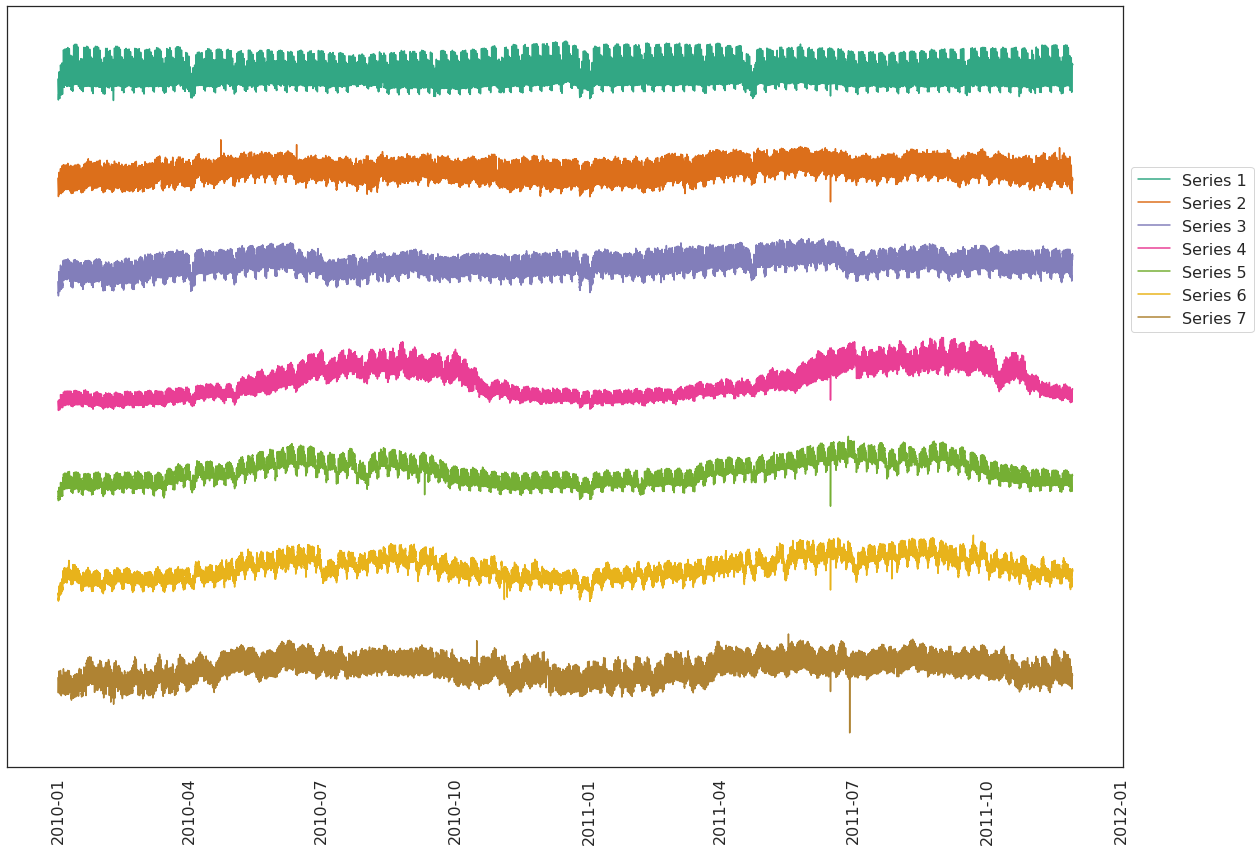

In [10]:
if  True:
    i = 0
    j = 0
    cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
    fig, ax = plt.subplots(figsize=(20,14))
    for ts in df_5:
      max_t = df_5[ts].max()
      plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label='Series '+str(i+1),alpha=.9)
      i += 1
      j -= 1
    plt.yticks([])
    plt.xticks(rotation=90, fontsize=16)
    plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16})
    plt.savefig('series.pdf')
    plt.show()

## Functions

In [11]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [12]:
def diff(list1,list2):
    difference = []
    zip_object = zip(list1, list2)
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    return difference

In [13]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-"; MAGE="FF00FF";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='series.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [14]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## We sort the 'pi' values and the largest one is selected.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## We sort the 'pi' values and select the largest
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## We order by 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)  
        prediction_Y2 = results.predict(X_2)
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [15]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2   
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2  
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2    
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2    
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)
    return prediction_Y2   
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    pl = PLSRegression(n_components=1)
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    la = Lasso(alpha=0.1)    
    pc = make_pipeline(PCA(n_components=1), LinearRegression())
    pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    la.fit(X, Y)
    pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr),("ri",ri),("la",la),("pc",pc)]) #,("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    return prediction_Y2   

In [16]:
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [17]:
def analogo_knn(serie,vsele,k=10,tol=0.8,n_components=3,typedist='pearson',typereg='OLSstep',id=0,verbose=False):
    ## vesele   : Size of the selection window / Tamanio de la ventana de selección
    ## k        : Number of neighbours to search for k / Número de vecinos a buscar k
    ## tol      : Window size tolerance for neighbour selection / Tolerancia de tamaño de ventanas para seleccion de vecinos
    ## typedist : distance measure, 'euclidian' or 'pearson' or 'dtw' / medida de distancia, 'euclidian' o 'pearson' o 'dtw' 
    t_o = time.time()
    n = len(serie) 

    ## STEP 1: Selection of the windows with the highest correlation.

    ## Calculate the distance between all neighbors.
    distances = []
    Y = serie[n-vsele:n]           ## latest data
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'euclidian':
            dist = euclidean(Y,serie[i:i+vsele])
        elif typedist == 'lb_keogh':
            dist = metrics.lb_keogh(ts_query=Y,ts_candidate=serie[i:i+vsele])  
        else:
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        if dist > 0:
            distances.append((i, dist))
        
    ## We calculate the neighbourhood by distance from smallest to largest and the positions are saved.
    if typedist == 'pearson':
        ## In the Pearson backwards case, we are interested in the indices with the highest correlation in Pearson backwards ordering.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## We calculate the k nearest neighbors and save the positions.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## if we already had a position in the list that passed the tolerance, we no longer save it
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## save new neighbor
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## position of k nearest neighbors

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    #vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selection with KNN:'+typedist,'demand','time',8,5,'selection_KNN'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

    ## STEP 2: Regression between nearest neighbors 'X' and last window 'Y'

    ## Define our regressors
    X   = (neighbors.T ).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []
    
    fail_=False
    try:        
        if typereg == 'OLSstep': ## -- OLS with Stepwise --
            prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)
        if typereg == 'RF':
            prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)
        if typereg == 'Boosting':
            prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   
        if typereg == 'Bagging':
            prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   
        if typereg == 'LinearReg':
            prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   
        if typereg == 'AdaBoost':
            prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  
        if typereg == 'BayesRidge':
            prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  
        if typereg == 'LassoReg':
            prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   
        if typereg == 'RidgeReg':
            prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)
        if typereg == 'PLS':
            prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)
        if typereg == 'PCR':
            prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)        
        if typereg == 'VotingEnsemble': ## -- Voting regression with ensemble models -- 
            prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)        
        if typereg == 'VotingLinear': ## -- Voting regression with linear model -- 
            prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
    except:   
        print(">>> analogo_knn: forecast not calculated.")
        prediction_Y2=[serie[-1]] * vsele
        prediction_Y2=np.array(prediction_Y2)
        fail_=True
        
    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Forecast - ' + typedist+' - ' + typereg ,'Demand','Time',8,5,'fig_t16_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o
    ## Draw an example of an analogous space with X, X' and Y, Y'
    if verbose==True:
        fig, ax = plt.subplots(figsize=(8,5))
        ax.legend(['First line', 'Second line'])
        serie1=serie[positions[0]:positions[0]+2*vsele]
        serie2=serie[positions[1]:positions[1]+2*vsele]
        serie3=serie[positions[2]:positions[2]+2*vsele]
        serie4=serie[positions[3]:positions[3]+2*vsele]
        serie5=serie[positions[4]:positions[4]+2*vsele]
        ax.plot(serie1, label='X$_1$')
        ax.plot(serie2, label='X$_2$')
        ax.plot(serie3, label='X$_3$')
        ax.plot(serie4, label='X$_4$')
        ax.plot(serie5, label='X$_5$')
        ax.plot(Y,label='Y', linewidth=3, color='r')   
        c = np.concatenate((Y,prediction_Y2), axis=0)   
        ax.plot(c, label='$Y\'$', linewidth=3, color='r',linestyle='--')      
        plt.legend()
        plt.axvline(x = vsele,linestyle='-.') # '-', '--', '-.', ':',
        ax.set(xlabel='time (5 min)', ylabel='demand (MW)') #title='High correlation windows'
        ax.grid()
        fig.savefig('test'+str(id)+'.pdf')
        plt.show()

    if verbose==True:
        print('fail_',fail_) 
        print('t_sel',t_sel) 
        print('t_reg',t_reg) 
        print('prediction_Y2',prediction_Y2) 

    return prediction_Y2, trunc(t_sel,6), trunc(t_reg,6), fail_

In [18]:
## Persistence forecasting
def persistence(serie,n=1):
    out=[]
    for i in range(n):        
        out.append(serie[-1])
    return(out)

In [19]:
## Function that given a datetime, returns its position in the series.
def get_index_day(df,day,month,year):
    df_i = df.reset_index()  ## Integer indices are added.
    idxo=df_i[(df_i.Date.dt.day==day)&(df_i.Date.dt.month==month)&(df_i.Date.dt.year==year)].iloc[ 0]
    idxf=df_i[(df_i.Date.dt.day==day)&(df_i.Date.dt.month==month)&(df_i.Date.dt.year==year)].iloc[-1]
    return(idxo.name,idxf.name)

# Prepare cross-validation for testing

We will use the methodology proposed by Rob J Hyndman [cross-validation in time series](https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
)


In [20]:
## https://robjhyndman.com/hyndsight/tscv/#:~:text=Time%20series%20cross%2Dvalidation,used%20in%20constructing%20the%20forecast.
## ... year 2010                                                                                                    year 2011
## ... january···february···march···april···may···june···july···august···september···october···november···december···january···february···march···april···may···june···july···august···september···october···november
##    |                                   |      |
##    |<------------- train ------------->|<test>|
##    |<-january·february···march···april->|<may>|
##            |<-february···march···april···may->|<june>|
##                      |<- march···april···may···june ->|<-july->|
##                              |<- april···may···june···july->|<-august->|
##                                     |<-- may···june···july···august->|<-september->|
##                                             |<-june···july···august···september->|<-october->|
##                                                    |<-july···august···september···october->|<-november->|
##                                                           |<-august···september···october···november->|<-december->| ...

df_5_month = df_5.copy()
df_5_month.reset_index(inplace=True)
# https://stackoverflow.com/a/25149272
df_5_month['month'] = df_5_month['Date'].dt.month
df_5_month['year'] = df_5_month['Date'].dt.year
df_5_month = df_5_month.drop_duplicates(['month', 'year'])
df_5_month.index

Int64Index([     0,   8928,  16992,  25920,  34560,  43488,  52128,  61056,
             69984,  78624,  87552,  96192, 105120, 114048, 122112, 131040,
            139680, 148608, 157248, 166176, 175104, 183744, 192672],
           dtype='int64')

In [21]:
## Get the positions (to,tt,tf) from cross-validation
month_i = df_5_month.index
r = range(len(month_i) - 5)
tuplas = []
for i in r:
  tuplas.append((
    # 1 ene       30 abril            31 may
    month_i[i], month_i[i + 4] - 1, month_i[i + 5] - 1
  ))
tuplas.append((157248, 192671, 200638))
tuplas

[(0, 34559, 43487),
 (8928, 43487, 52127),
 (16992, 52127, 61055),
 (25920, 61055, 69983),
 (34560, 69983, 78623),
 (43488, 78623, 87551),
 (52128, 87551, 96191),
 (61056, 96191, 105119),
 (69984, 105119, 114047),
 (78624, 114047, 122111),
 (87552, 122111, 131039),
 (96192, 131039, 139679),
 (105120, 139679, 148607),
 (114048, 148607, 157247),
 (122112, 157247, 166175),
 (131040, 166175, 175103),
 (139680, 175103, 183743),
 (148608, 183743, 192671),
 (157248, 192671, 200638)]

## Public holidays

In [22]:
serie='SERIE1'
print(get_index_day(df_5[serie],10,5,2010))   ## mothers day 2010
print(get_index_day(df_5[serie],10,5,2011))   ## mothers day 2011
print(get_index_day(df_5[serie],24,12,2010))  ## christmas 2010
print(get_index_day(df_5[serie],31,12,2010))  ## new year 2011
print(get_index_day(df_5[serie],1,1,2011))    ## new year 2011

(37152, 37439)
(142272, 142559)
(102816, 103103)
(104832, 105119)
(105120, 105407)


# We select a serie and set its parameters

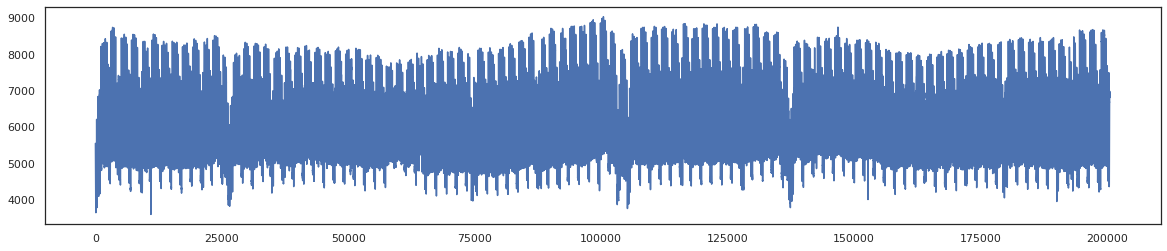

In [23]:
serie1 = df_5.SERIE1.tolist()
plt.figure(figsize=(20, 4))
plt.plot(serie1)
npserie1 = numpy.array(serie1)

In [24]:
## ene2010... time serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·time-serie·nov2011
##                |                                               |       |           |
##                |                                               |<-n_p->|           |
##                |<------------------ train -------------------->|<-------test------>|
##                to                                              tt   ...j=0...      tf 
seriesname= 'series1'
monthyear = 'jun2010'
n_p       = 30         ## Number of periods per step (Two and half hour)
vsele     = 288        ## Number of periods in a window (a day)
k         = 5          ## Number of nearest neighbors
tol       = 0.8        ## Closest tolerance percentage between neighbors
typedist  = 'lb_keogh'  ## Distance betweeen neighbors 'pearson' 'euclidian' 'dtw' 'lb_keogh'
typereg   = 'PCR'      ## Regression model 'OLSstep' 'Boosting' 'Bagging' 'LinearReg' 'AdaBoost' 
                       ##'BayesRidge' 'LassoReg' 'RidgeReg' 'PLS' 'PCR' 'VotingEnsemble' 'VotingLinear'

In [25]:
# >>> provisional para pruebas preliminares (-comentar-)
positions_test= [(9218, 43770, 43780)]  ## falla
positions_test= [(8928, 43487, 46487)]  ## Predecir junio
positions_test= [(11239, 45798, 46487)] ## Predecir junio
positions_test= [(11239, 45798, 46798)] ## Predecir junio

# Multi-period **analogue** forecast metafunction:

In [26]:
## Persistence (t=t+1)
forecastp_ = []
timep_      = []
for to,tt,tf in positions_test:
    j=0
    for i in range(tt,tf,1):
        t_o = time.time()
        forecastp_=forecastp_+persistence(serie1[to+j:tt+j],1)
        timep_.append(time.time() - t_o)
        j=j+1

In [27]:
## Prepare the test series
test_ = []
for to,tt,tf in positions_test:
      test_ = test_ + serie1[tt:tf]
print(len(test_))

200


In [ ]:
t_sel           = []
t_reg           = []
forecastAn_     = []
forecastAnMA_   = []
forecastX_An_   = []
forecastX_AnMA_ = []
nfail = 0
fail  = []
for to,tt,tf in positions_test:
    j=0
    s=n_p
    for i in range(tt,tf,1):
        print(j,tt+j)
        ## Analogue method parameters
        X_train  = np.array(serie1[to+j:tt+j])
        verbose=False
        fail_ = False
        pred_, t_sel_, t_reg_, fail_ = analogo_knn(X_train, vsele=vsele, k=k, tol=tol, typedist=typedist, typereg=typereg,id=tt+j, verbose=verbose)
        t_sel.append(t_sel_)
        t_reg.append(t_reg_)

        if fail_==True:              
            nfail = nfail + 1
            print(">>> Persistence forecast in position:",tt+j)
            fail.append(tt + j)
        pred_list  = pred_.tolist() 
        forecastAn_ = forecastAn_ + pred_list[0:1]
        if j >= n_p :
            a = -min(j,vsele) -1
            b = -1
            array1 = np.array(forecastAn_[a:b])
            c = tt + j - min(j,vsele)
            d = tt + j
            array2 = np.array(serie1[c:d])                         
            epsilon = np.subtract(array1,array2) ## Errores del primer pronóstico
            ar = AutoReg(epsilon, lags=1).fit()  ## 3*n_p        
            delta = ar.forecast(1)
            MA_ = pred_list[0:1] - delta
            forecastAnMA_.extend(MA_)
            if s==n_p:
                forecastX_An_   = forecastX_An_ + pred_list[0:n_p]
                MA_ = pred_list[0:n_p] - delta
                forecastX_AnMA_.extend(MA_)
                s=0           
        else:
            if s==n_p:
                forecastX_An_   = forecastX_An_ + pred_list[0:n_p]
                forecastX_AnMA_ = forecastX_An_
                s=0            
            forecastAnMA_ = forecastAn_

        j=j+1
        s=s+1

    modu=(tf-tt)%n_p
    if modu != 0:
        end=min(len(forecastAn_),len(forecastX_An_))
        print('modu',modu)
        forecastAn_    = forecastAn_[    0:end]
        forecastAnMA_  = forecastAnMA_[  0:end]    
        forecastX_An_  = forecastX_An_[  0:end]
        forecastX_AnMA_= forecastX_AnMA_[0:end]    
print('>>>Number of forecasts not calculated:', nfail)
print(fail)

In [29]:
end=min(len(forecastAn_),len(forecastX_An_))
forecastAn_    = forecastAn_[    0:end]
forecastAnMA_  = forecastAnMA_[  0:end]    
forecastX_An_  = forecastX_An_[  0:end]
forecastX_AnMA_= forecastX_AnMA_[0:end]    
forecastp_= forecastp_[0:end]       
test_= test_[0:end]    

In [30]:
date_i = df_5.reset_index().iloc[tt].Date

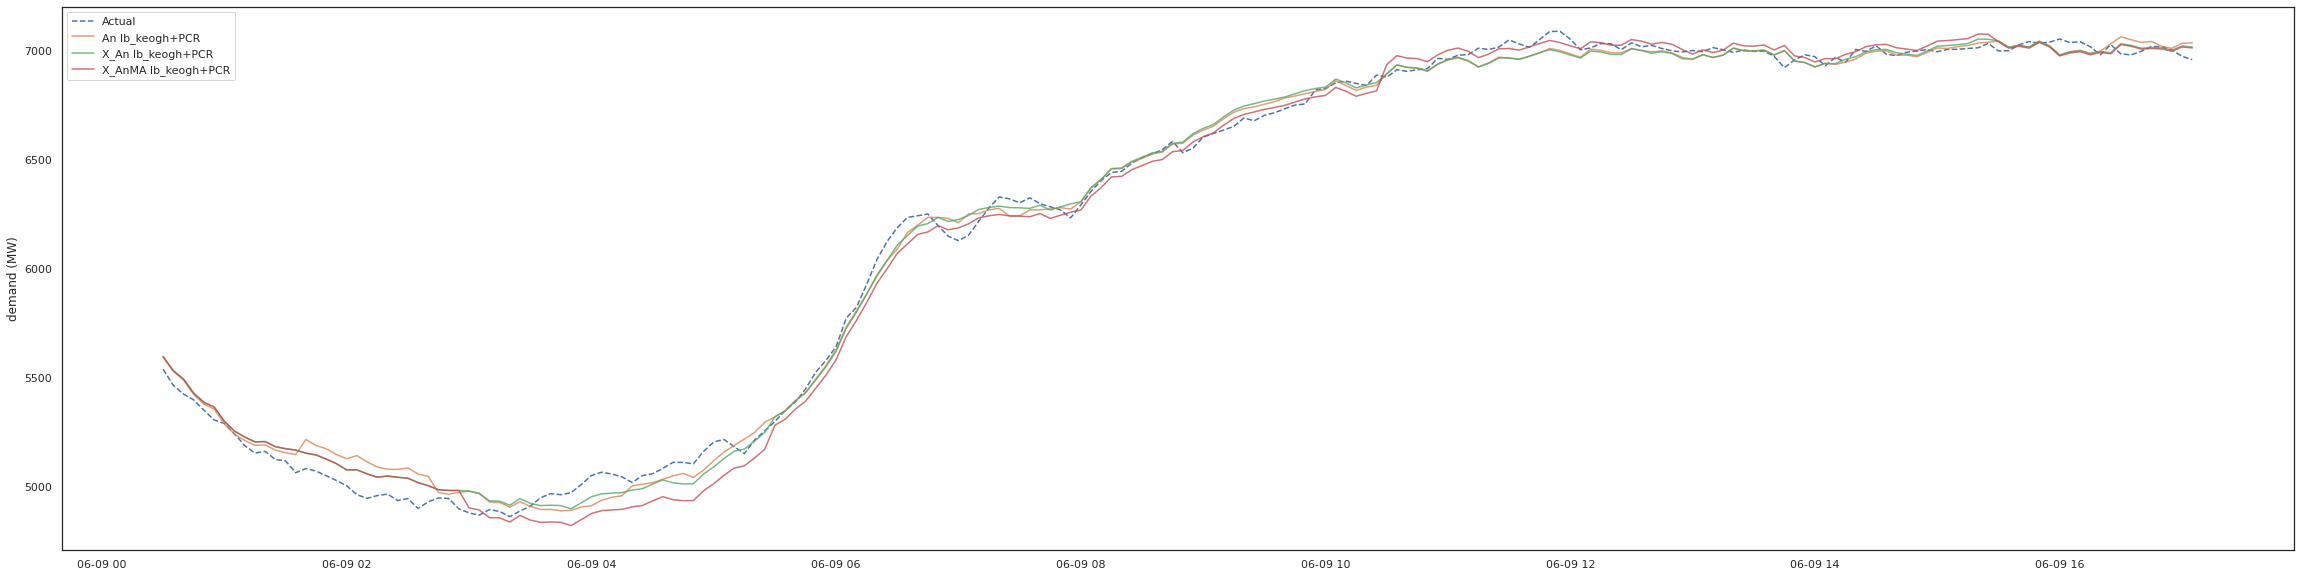

In [31]:
df_results = pd.DataFrame({
  'datetime'          : pd.date_range(date_i, periods=len(test_), freq="5T"),
  'Actual'            : test_,
  #'Persistence'       : forecastp_,
  'An '    +typedist+'+'+typereg   : forecastAn_,
  #'AnMA '  +typedist+'+'+typereg   : forecastAnMA_,
  'X_An '  +typedist+'+'+typereg   : forecastX_An_,
  'X_AnMA '+typedist+'+'+typereg   : forecastX_AnMA_,
})
df_results = df_results.set_index('datetime')

df_results.to_csv('results_'+serie+'_'+monthyear+'.csv')

plt.figure(figsize=(40, 10))
for c in df_results:
  if c == 'Actual':
    plt.plot(df_results[c], '--', label = c)
  else:
    plt.plot(df_results[c], label = c, alpha=0.8)
plt.legend()
plt.ylabel('demand (MW)')
plt.savefig('series_'+seriesname+'_'+monthyear+'.pdf')
plt.show()

In [32]:
a=0; b=2000
mae_p  = mean_absolute_error(test_[a:b],forecastp_[a:b])
mape_p = mean_absolute_percentage_error(test_[a:b],forecastp_[a:b])
bias_p = bias.bias(test_[a:b],forecastp_[a:b])

In [33]:
mae_a  = mean_absolute_error(test_[a:b],forecastAn_)
mape_a = mean_absolute_percentage_error(test_[a:b],forecastAn_[a:b])
bias_a = bias.bias(test_[a:b],forecastAn_[a:b])

In [34]:
mae_ma  = mean_absolute_error(test_[a:b],forecastAnMA_[a:b])
mape_ma = mean_absolute_percentage_error(test_[a:b],forecastAnMA_[a:b])
bias_ma = bias.bias(test_[a:b],forecastAnMA_[a:b])

In [35]:
mae_xa  = mean_absolute_error(test_[a:b],forecastX_An_)
mape_xa = mean_absolute_percentage_error(test_[a:b],forecastX_An_[a:b])
bias_xa = bias.bias(test_[a:b],forecastX_An_[a:b])

In [36]:
mae_xma  = mean_absolute_error(test_[a:b],forecastX_AnMA_)
mape_xma = mean_absolute_percentage_error(test_[a:b],forecastX_AnMA_[a:b])
bias_xma = bias.bias(test_[a:b],forecastX_AnMA_[a:b])

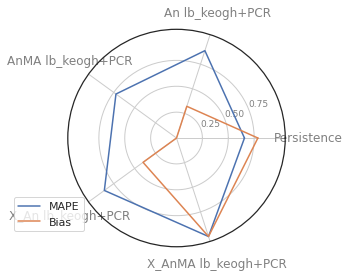

In [37]:
df_resultados = pd.DataFrame([
  {
    'method': 'Persistence',
    'mape'  : mape_p,
    'mae'   : mae_p, # Conviene normalizar esto (o quitarlo porque normalizado es como el mape)
    'bias'  : bias_p # Conviene normalizar esto
  },
  {
    'method': 'An '+typedist+'+'+typereg,
    'mape'  : mape_a,
    'mae'   : mae_a, 
    'bias'  : bias_a 
  },
  {
    'method': 'AnMA '+typedist+'+'+typereg,
    'mape'  : mape_ma,
    'mae'   : mae_ma,
    'bias'  : bias_ma 
  },
  {
    'method': 'X_An '+typedist+'+'+typereg,
    'mape'  : mape_xa,
    'mae'   : mae_xa,
    'bias'  : bias_xa 
  },  
  {
    'method': 'X_AnMA '+typedist+'+'+typereg,
    'mape'  : mape_xma,
    'mae'   : mae_xma,
    'bias'  : bias_xma
  },
  # etc.
])
categories = df_resultados.method
N = len(categories)

fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

theta = np.arange(len(df_resultados) + 1) / float(len(df_resultados)) * 2 * np.pi

values = df_resultados.mape.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="MAPE")

values = df_resultados.bias.values
values = np.append(values, values[0])
values = values + abs(min(values))
values = values / max(values)
ax.plot(theta, values, label="Bias")

plt.xticks(theta[:-1], df_resultados.method, color='grey', size=12)
plt.yticks([0.25, 0.50, 0.75], ['0.25', '0.50', '0.75'], color='grey', size=9)
ax.tick_params(pad=10) # to increase the distance of the labels to the plot

plt.legend(loc='center right', bbox_to_anchor=(0.1, 0.15))

namefile = 'polar_'+seriesname+'_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

time_jun2010 selection 3.9648163450000005
time_jun2010 regresion 0.0028701100000000004


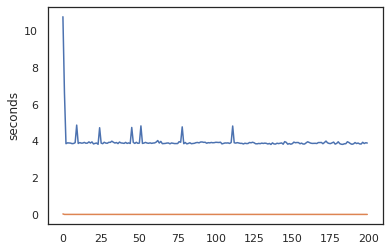

In [38]:
## mean time of selection and regression in seconds
plt.plot(t_sel,)
plt.plot(t_reg,)
plt.ylabel('seconds')
print('time_'+monthyear+' selection',(np.mean(t_sel)))
print('time_'+monthyear+' regresion',(np.mean(t_reg)))
namefile = 'time_'+seriesname+'_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)

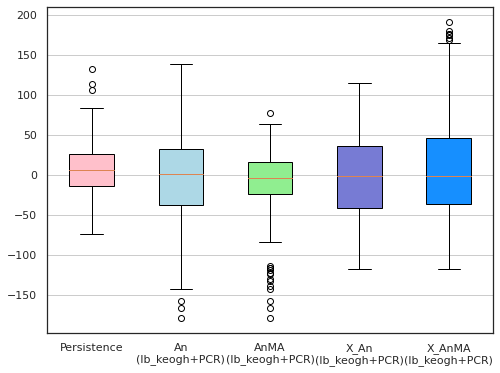

In [39]:
data = [diff(test_,forecastp_), diff(test_,forecastAn_), diff(test_,forecastAnMA_), diff(test_,forecastX_An_), diff(test_,forecastX_AnMA_)]
labels = ['Persistence', 'An\n('+typedist+'+'+typereg+')', 'AnMA\n('+typedist+'+'+typereg+')', 'X_An\n('+typedist+'+'+typereg+')', 'X_AnMA\n('+typedist+'+'+typereg+')',]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "#FF0000"; # 'pink', 'lightblue', 'lightgreen',
#plt.tick_params(colors = LETRASNARA, which='both')
bplot1 = axes.boxplot(data,
                      vert=True,          # vertical box alignment
                      patch_artist=True,  # fill with color
                      labels=labels,)     # will be used to label x-ticks
#axes.set_title('Accuracy',fontsize='x-large',color = LETRASNARA)
#plt.tick_params(colors = LETRASNARA, which='both')
colors = ['pink', 'lightblue', 'lightgreen',LILA, AZUL] # fill with colors
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
axes.yaxis.grid(True) # adding horizontal grid lines
#axes.set_xlabel('Configuraciones de red',fontsize='large',color = LETRASNARA)
axes.set_ylabel('')
namefile = 'boxplot_'+seriesname+'_'+monthyear+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

# Interesting links
 
 [From Linear Regression to Ridge Regression, the Lasso, and the Elastic Net](https://towardsdatascience.com/from-linear-regression-to-ridge-regression-the-lasso-and-the-elastic-net-4eaecaf5f7e6)

[Regularización Ridge, Lasso y Elastic Net con Python](https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html)